# Set up

Setting up libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Data

/content/drive/My Drive/Colab Notebooks/Data


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
import pickle

from skimage.transform import radon, iradon
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
keras.utils.set_random_seed(SEED)

# Creating train,valid, and test data sets

## Function for creating sinograms from CT scans

Modified from code found on https://github.com/shenlongleon/BME590-Final-Project/blob/master/FinalProject_data_processing.ipynb

In [ ]:
def new_sino(string):
  files = sorted(glob.glob(string))
  images = np.array([cv2.imread(path) for path in files])
  
  images = np.array([cv2.resize(images,(256,256)) for images in images])

  gray_images = np.zeros((images.shape[0], 256, 256))
  def rgb2gray(img):
      return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
  for i in range(images.shape[0]):
      gray_images[i, ...] = rgb2gray(images[i, ...]) 
  
  proj_num = 180
  new_images = np.zeros((images.shape[0], 256, 256))
  for i in range(images.shape[0]):
    rad = radon(gray_images[i], theta=np.arange(0, 180, 1), preserve_range=True)
    x_reshape_radon = np.ones((256,256))

    for num in range(proj_num):
        begin = int(num * 256/proj_num)
        end = int(256/proj_num*(num+1))
        for col in range(begin, end,1):
            x_reshape_radon[:,col] = rad[:,num]
    new_images[i,...] = x_reshape_radon
  new_images = np.repeat(new_images[..., np.newaxis], 3, -1)
  return new_images 

## Create train set

In [ ]:
train_adeno = new_sino('./train/adeno/*.png')
train_large = new_sino('./train/large/*.png')
train_norm = new_sino('./train/normal/*.png')
train_squam = new_sino('./train/squam/*.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


In [ ]:
train = np.concatenate((train_adeno, train_large,train_norm,train_squam))

In [ ]:
train_adeno_label = np.full((len(train_adeno), 1), 0)
train_large_label = np.full((len(train_large), 1), 1)
train_norm_label = np.full((len(train_norm), 1), 2)
train_squam_label = np.full((len(train_squam), 1), 3)

train_labels = np.concatenate((train_adeno_label, train_large_label,train_norm_label,train_squam_label))
train_labs = np.squeeze((np.eye(4)[train_labels]),1)

Visualizing a sample CT scan

In [ ]:
files = sorted(glob.glob('./train/adeno/*.png'))
images = np.array([cv2.imread(path) for path in files])
images = np.array([cv2.resize(images,(256,256)) for images in images])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Text(0.5, 1.0, 'Sample CT Scan of Adenocarcinoma')

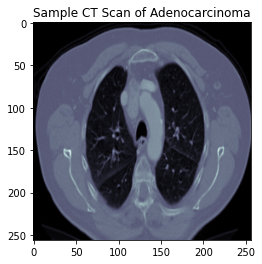

In [ ]:
plt.imshow(images[0,:,:,0], cmap='bone')
plt.title('Sample CT Scan of Adenocarcinoma')

Visualizing a sample sinogram

Text(0.5, 1.0, 'Sample sinogram of Adenocarcinoma')

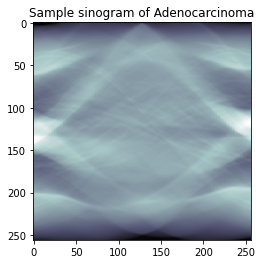

In [ ]:
plt.imshow(train[0,:,:,0], cmap='bone')
plt.title('Sample sinogram of Adenocarcinoma')

## Create valid set

In [ ]:
valid_adeno = new_sino('./valid/adeno/*.png')
valid_large = new_sino('./valid/large/*.png')
valid_norm = new_sino('./valid/normal/*.png')
valid_squam = new_sino('./valid/squam/*.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


In [ ]:
valid = np.concatenate((valid_adeno, valid_large,valid_norm,valid_squam))

In [ ]:
valid_adeno_label = np.full((len(valid_adeno), 1), 0)
valid_large_label = np.full((len(valid_large), 1), 1)
valid_norm_label = np.full((len(valid_norm), 1), 2)
valid_squam_label = np.full((len(valid_squam), 1), 3)

valid_labels = np.concatenate((valid_adeno_label, valid_large_label,valid_norm_label,valid_squam_label))
valid_labs = np.squeeze((np.eye(4)[valid_labels]),1)

## Create test set

In [ ]:
test_adeno = new_sino('./test/adeno/*.png')
test_large = new_sino('./test/large/*.png')
test_norm = new_sino('./test/normal/*.png')
test_squam = new_sino('./test/squam/*.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


In [ ]:
test = np.concatenate((test_adeno, test_large,test_norm,test_squam))

In [ ]:
test_adeno_label = np.full((len(test_adeno), 1), 0)
test_large_label = np.full((len(test_large), 1), 1)
test_norm_label = np.full((len(test_norm), 1), 2)
test_squam_label = np.full((len(test_squam), 1), 3)

test_labels = np.concatenate((test_adeno_label, test_large_label,test_norm_label,test_squam_label))
test_labs = np.squeeze((np.eye(4)[test_labels]),1)

## Saving variables with pickle

In [ ]:
with open('variables', 'wb') as f:
  pickle.dump([train,train_labs,valid,valid_labs,test,test_labs,test_labels],f)